### 9. Fragmented replay composition and behavior

### (Use `TrialChoiceReplayTransition` and plot with behavior side by side.)
[This notebook uses TrialChoiceReplay().]
##### All the tables mentioned above are under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.

Aug 21, 2024
Shijie Gu

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os
import pickle
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

In [3]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,TrialChoiceReplayTransition
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP,load_position
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,ExtendInterSection,InterSection,
                                                plot_ripple,threshold_by_zscore_Gu,
                                                Kay_ripple_detector,Karlsson_ripple_detector,Gu_ripple_detector,multiunit_HSE_detector,
                                                removeDataBeforeTrial1,removeArtifactTime,
                                                loadRippleLFP_OneChannelPerElectrode,ripple_detection_master)
from spyglass.shijiegu.Analysis_SGU import (TetrodeNumber,MUA,ExtendedTrialChoiceReplay,ExtendedRippleTimes,RippleTimesWithDecode)
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_task import TaskEpoch

[2025-04-12 15:15:37,375][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2025-04-12 15:15:37,529][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [4]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import replay_transitions,behavior_transitions,findXCorrAllDays

from spyglass.shijiegu.fragmented_general import cont_vs_frag_occurrence_day

In [5]:
from spyglass.shijiegu.load import load_run_sessions

In [6]:
from spyglass.common.common_position import IntervalPositionInfo
from spyglass.shijiegu.load import load_run_sessions
from spyglass.shijiegu.Analysis_SGU import RippleTimesWithDecode, TrialChoice
from spyglass.shijiegu.ripple_detection import removeDataBeforeTrial1

### Specify which decoding model to use and days

In [85]:
animal = 'Eliot'
dates_to_plot = ['20221017','20221018','20221019','20221020','20221021','20221022','20221023','20221024','20221025','20221026']

encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_0SD'
datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [40]:
animal = 'Lewis'
dates_to_plot = ['20240105','20240106','20240107','20240108','20240109','20240110']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

In [68]:
animal = 'Lewis'
animal_save_name = 'Lewis2'

dates_to_plot = ['20240116','20240117','20240118','20240119','20240120']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

# load behavior data
datafolder='/cumulus/shijie/behavior_pilot/Batch1'

In [8]:
animal = 'Molly'
animal_save_name = 'Molly'

dates_to_plot = ['20220416','20220417','20220418','20220419','20220420']

encoding_set = '2Dheadspeed_above_4'
classifier_param_name = 'default_decoding_gpu_4armMaze'
decode_threshold_method = 'MUA_M05SD'

datafolder='/stelmo/shijie/behavior_pilot/Batch1'

In [53]:
StateScript = pd.DataFrame(
                (TrialChoice & {'nwb_file_name':"lewis20240105_.nwb",'epoch_name':"10_Rev2Session5"}).fetch1('choice_reward'))

In [54]:
StateScript

,timestamp_H,Home,timestamp_O,OuterWellIndex,rewardNum,current,future_H,future_O,past,past_reward
1,1.704497e+09,1.0,1.704497e+09,1.0,2.0,1.0,1.0,3.0,NaN,NaN
2,1.704497e+09,1.0,1.704497e+09,3.0,1.0,3.0,3.0,2.0,1.0,1.0
3,1.704497e+09,1.0,1.704497e+09,2.0,2.0,2.0,2.0,4.0,3.0,1.0
4,1.704497e+09,1.0,1.704497e+09,4.0,2.0,4.0,4.0,1.0,2.0,2.0
5,1.704497e+09,1.0,1.704497e+09,1.0,1.0,1.0,1.0,3.0,4.0,4.0
6,1.704497e+09,1.0,1.704497e+09,3.0,2.0,3.0,3.0,2.0,1.0,4.0
7,1.704497e+09,1.0,1.704497e+09,2.0,1.0,2.0,2.0,1.0,3.0,3.0
8,1.704497e+09,1.0,1.704497e+09,1.0,2.0,1.0,1.0,2.0,2.0,3.0
9,1.704497e+09,1.0,1.704497e+09,2.0,2.0,2.0,2.0,4.0,1.0,1.0
10,1.704497e+09,1.0,1.704497e+09,4.0,2.0,4.0,4.0,2.0,2.0,2.0


In [86]:
for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)

    (num_cont_day, num_frag_day,
    pct_cont_day, pct_frag_day,
     time_cont_day, time_frag_day) = ([],[],[],[],[],[])
    num_all_day = 0

    for ind in range(len(run_session_names)):
        session_name = run_session_names[ind]
        StateScript = pd.DataFrame(
                (TrialChoice & {'nwb_file_name':nwb_copy_file_name,'epoch_name':session_name}).fetch1('choice_reward'))
        if len(StateScript) < 20:
            continue

        trial_1_t = StateScript.loc[1].timestamp_O
        trial_last_t = StateScript.loc[len(StateScript)-1].timestamp_O
        session_duration = trial_last_t - trial_1_t

        key = {'nwb_file_name': nwb_copy_file_name,
                'interval_list_name': session_name,
                'classifier_param_name': classifier_param_name,
                'encoding_set': encoding_set,
                'decode_threshold_method':decode_threshold_method}

        try:
            ripple_times = pd.read_pickle((RippleTimesWithDecode & key).fetch1('ripple_times'))
        except:
            ripple_times = pd.DataFrame((RippleTimesWithDecode & key).fetch1('ripple_times'))

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221017_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221017_ 2         02_Seq2Session pos 1 valid ti
eliot20221017_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221017_ 4         04_Seq2Session pos 3 valid ti
eliot20221017_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221017_ 6         06_Seq2Session pos 5 valid ti
eliot20221017_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221017_ 8         08_Seq2Session pos 7 valid ti
eliot20221017_ 9         09_Seq2Sleep5  pos 8 valid ti
 (Total: 9)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221018_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221018_ 2         02_Seq2Session pos 1 valid ti
eliot20221018_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221018_ 4         04_Seq2Session pos 3 valid ti
eliot20221018_ 5         05_Seq2Session pos 4 valid 

In [87]:
print("eliot20221016_.nwb")
RippleTimesWithDecode & {'nwb_file_name': nwb_copy_file_name}

eliot20221016_.nwb


nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,classifier_param_name a name for this set of parameters,encoding_set a name for this set of encoding,decode_threshold_method a name for this thresholding method,ripple_times ripple times within that interval
eliot20221026_.nwb,02_Seq2Session1,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,MUA_0SD,=BLOB=
eliot20221026_.nwb,04_Seq2Session2,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,MUA_0SD,=BLOB=
eliot20221026_.nwb,06_Seq2Session3,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,MUA_0SD,=BLOB=
eliot20221026_.nwb,08_Seq2Session4,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,MUA_0SD,=BLOB=
eliot20221026_.nwb,10_Seq2Session5,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,MUA_0SD,=BLOB=
eliot20221026_.nwb,12_Seq2Session6,default_decoding_gpu_4armMaze,2Dheadspeed_above_4_andlowmua,MUA_0SD,=BLOB=


In [88]:
(num_all, 
 num_cont_all, num_frag_all, 
 pct_cont_all, pct_frag_all, 
 time_cont_all, time_frag_all) = cont_vs_frag_occurrence_day(animal,dates_to_plot,
                                                             encoding_set,classifier_param_name,decode_threshold_method)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221017_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221017_ 2         02_Seq2Session pos 1 valid ti
eliot20221017_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221017_ 4         04_Seq2Session pos 3 valid ti
eliot20221017_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221017_ 6         06_Seq2Session pos 5 valid ti
eliot20221017_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221017_ 8         08_Seq2Session pos 7 valid ti
eliot20221017_ 9         09_Seq2Sleep5  pos 8 valid ti
 (Total: 9)

immobile time is  1109.5185105800629 seconds.
immobile time is  1142.0600321292877 seconds.
immobile time is  1161.0637774467468 seconds.
immobile time is  1115.7532560825348 seconds.
*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221018_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221018_ 2         02_Seq2S

### plot by session

#### load behavior

In [89]:
sequence_datapath = os.path.join(datafolder,animal,'behavior_metaSequence_'+animal+'.p')
data_pair=pickle.load(open(os.path.join(datafolder,'behavior_correctPair_'+animal+'.p'), "rb"))

with open(sequence_datapath, 'rb') as f:
    behavior_data = pickle.load(f)  
    
total_trial_num = {}
occurance_rates = {}
pct_correct = {}
seq_types = {}

for day in dates_to_plot:
    subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(day)).ravel()
    
    total_trial_num_day = np.zeros(len(subset_ind))
    occurance_rates_day = np.zeros((len(subset_ind),6))
    pct_correct_day = np.zeros((len(subset_ind),6))
    seq_types_day = np.zeros(len(subset_ind))
    
    print(day)
    print(len(subset_ind))
    
    for n in range(len(subset_ind)):

        session_ind = subset_ind[n]
        total_trial_num_day[n] = len(behavior_data['outersAll'][session_ind])
        seq_types_day[n] = behavior_data['seqtype_int'][session_ind]
        for seq in range(6):
            occurance_rates_day[n,seq] = np.mean(behavior_data['occurance_rates'][seq][session_ind])
            pct_correct_day[n,seq] = data_pair['pctCorrect'][session_ind][seq]
    
    total_trial_num[day] = total_trial_num_day
    occurance_rates[day] = occurance_rates_day
    seq_types[day] = seq_types_day
    pct_correct[day] = pct_correct_day

20221017
4
20221018
5
20221019
5
20221020
6
20221021
4
20221022
5
20221023
4
20221024
5
20221025
4
20221026
6


In [90]:
label = []
for d in dates_to_plot:
    nwb_copy_file_name = animal.lower() + d + '_.nwb'
    run_session_ids, run_session_names, pos_session_names = load_run_sessions(nwb_copy_file_name)
    
    for ind in range(len(run_session_names)):
        session_name = run_session_names[ind]
        StateScript = pd.DataFrame(
            (TrialChoice & {'nwb_file_name':nwb_copy_file_name,'epoch_name':session_name}).fetch1('choice_reward'))
            
        if len(StateScript) < 30:
            continue
        
        label.append(d[6:9]+'\n'+str(run_session_ids[ind]))

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221017_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221017_ 2         02_Seq2Session pos 1 valid ti
eliot20221017_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221017_ 4         04_Seq2Session pos 3 valid ti
eliot20221017_ 5         05_Seq2Sleep3  pos 4 valid ti
eliot20221017_ 6         06_Seq2Session pos 5 valid ti
eliot20221017_ 7         07_Seq2Sleep4  pos 6 valid ti
eliot20221017_ 8         08_Seq2Session pos 7 valid ti
eliot20221017_ 9         09_Seq2Sleep5  pos 8 valid ti
 (Total: 9)

*nwb_file_name *epoch    epoch_name     position_inter
+------------+ +-------+ +------------+ +------------+
eliot20221018_ 1         01_Seq2Sleep1  pos 0 valid ti
eliot20221018_ 2         02_Seq2Session pos 1 valid ti
eliot20221018_ 3         03_Seq2Sleep2  pos 2 valid ti
eliot20221018_ 4         04_Seq2Session pos 3 valid ti
eliot20221018_ 5         05_Seq2Session pos 4 valid 

In [91]:
behavior_data.keys()

dict_keys(['outersAll', 'outersAll_b', 'level', 'orders', 'seqtype', 'seqtype_int', 'dateIntAll', 'occurance_rates', 'occurance_rates_boot25_any', 'occurance_rates_boot975_any'])

In [92]:
len(time_cont_plot)

20

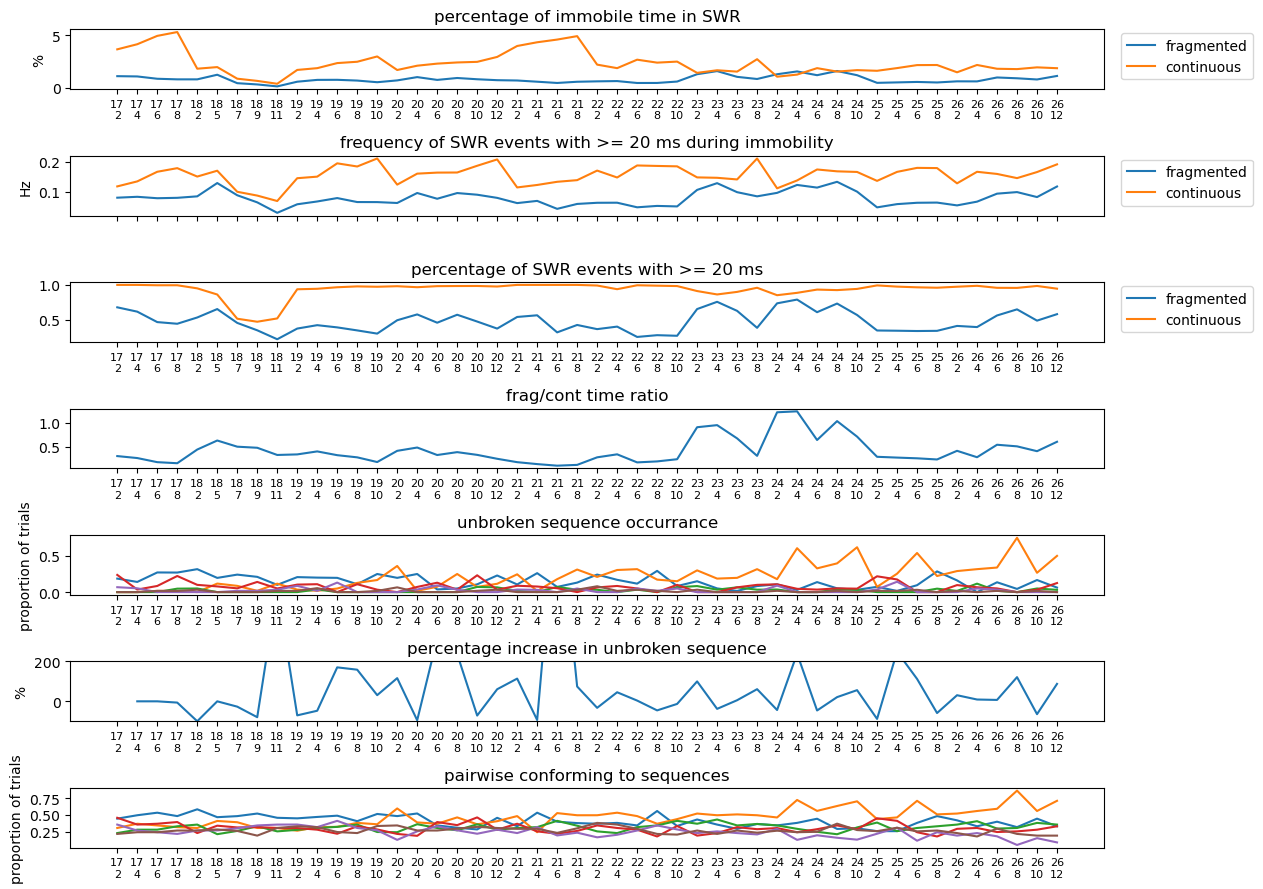

In [93]:
occurance_rates_all = np.concatenate([occurance_rates[k] for k in occurance_rates])
seq_types_all = np.concatenate([seq_types[k] for k in seq_types])

correct_seq_occurance = [
    occurance_rates_all[session_ind,int(seq_types_all[session_ind]-1)] for session_ind in range(len(seq_types_all))]

time_cont_plot = np.concatenate([time_cont_all[d] for d in dates_to_plot])
time_frag_plot = np.concatenate([time_frag_all[d] for d in dates_to_plot])

num_cont_plot = np.concatenate([num_cont_all[d] for d in dates_to_plot])
num_frag_plot = np.concatenate([num_frag_all[d] for d in dates_to_plot])

pct_cont_plot = np.concatenate([pct_cont_all[d] for d in dates_to_plot])
pct_frag_plot = np.concatenate([pct_frag_all[d] for d in dates_to_plot])

fig, axes = plt.subplots(7,1, figsize = (8 * len(time_cont_plot)/30,9),sharex = True)
axes[0].plot(time_frag_plot*100, label = 'fragmented')
axes[0].plot(time_cont_plot*100, label = 'continuous')
axes[0].set_xticks(np.arange(len(label)));
axes[0].set_xticklabels(label,fontsize = 8);
axes[0].set_title('percentage of immobile time in SWR')
axes[0].set_ylabel('%')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))
axes[0].xaxis.set_tick_params(labelbottom=True)

axes[1].plot(num_frag_plot, label = 'fragmented')
axes[1].plot(num_cont_plot, label = 'continuous')
axes[1].set_xticks(np.arange(len(label)));
axes[1].set_xticklabels(label,fontsize = 8);
axes[1].set_title('frequency of SWR events with >= 20 ms during immobility')
axes[1].set_ylabel('Hz')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))
axes[2].xaxis.set_tick_params(labelbottom=True)

axes[2].plot(pct_frag_plot, label = 'fragmented')
axes[2].plot(pct_cont_plot, label = 'continuous')
axes[2].set_xticks(np.arange(len(label)));
axes[2].set_xticklabels(label,fontsize = 8);
axes[2].set_title('percentage of SWR events with >= 20 ms')
axes[2].legend(bbox_to_anchor=(1.01, 1.05))
axes[2].xaxis.set_tick_params(labelbottom=True)

axes[3].plot(time_frag_plot/time_cont_plot)
axes[3].set_xticks(np.arange(len(label)));
axes[3].set_xticklabels(label,fontsize = 8);
axes[3].set_title('frag/cont time ratio')
axes[3].set_ylabel('')
axes[3].xaxis.set_tick_params(labelbottom=True)

axes[4].plot(np.concatenate([occurance_rates[k] for k in occurance_rates]))
axes[4].set_xticks(np.arange(len(label)));
axes[4].set_xticklabels(label,fontsize = 8);
axes[4].xaxis.set_tick_params(labelbottom=True)
axes[4].set_title('unbroken sequence occurrance')
axes[4].set_ylabel('proportion of trials')

pct_increase = 100 * np.diff(correct_seq_occurance)/(np.array(correct_seq_occurance[:-1]))
pct_increase[np.isnan(pct_increase)] = 0
pct_increase[np.isinf(pct_increase)] = 0

axes[5].plot(np.arange(len(label))[1:],pct_increase)
axes[5].set_xticks(np.arange(1,len(label)));
axes[5].set_xticklabels(label[1:],fontsize = 8);
axes[5].set_title('percentage increase in unbroken sequence')
axes[5].set_ylabel('%')
axes[5].xaxis.set_tick_params(labelbottom=True)
axes[5].set_ylim([-100,200])


axes[6].plot(np.concatenate([pct_correct[k] for k in pct_correct]))
axes[6].set_xticks(np.arange(len(label)));
axes[6].set_xticklabels(label,fontsize = 8);
axes[6].set_title('pairwise conforming to sequences')
axes[6].set_ylabel('proportion of trials')



#axes[3].plot(np.array(trial_number) / np.array([total_trial_num[k] for k in total_trial_num]))


fig.tight_layout()

### plot by day

In [94]:
time_cont_day = [np.mean(time_cont_all[d]) for d in dates_to_plot]
time_frag_day = [np.mean(time_frag_all[d]) for d in dates_to_plot]

num_cont_day = [np.mean(num_cont_all[d]) for d in dates_to_plot]
num_frag_day = [np.mean(num_frag_all[d]) for d in dates_to_plot]

pct_cont_day = [np.sum(num_cont_all[d])/num_all[d] for d in dates_to_plot]
pct_frag_day = [np.sum(num_frag_all[d])/num_all[d] for d in dates_to_plot]

occurance_rates_day = np.concatenate([np.mean(occurance_rates[d],axis = 0).reshape((1,6)) for d in dates_to_plot])


correct_seq_occurance_day = []
for d in dates_to_plot:
    tmp = []
    total_trial_num = 0
    
    subset_ind = np.argwhere(behavior_data['dateIntAll'] == int(d)).ravel()

    
    for n in range(len(subset_ind)):
        session_ind = subset_ind[n]
        trial_num_session = len(behavior_data['outersAll'][session_ind])
        total_trial_num += trial_num_session
        seq_types_session = behavior_data['seqtype_int'][session_ind]

        tmp.append(np.mean(behavior_data['occurance_rates'][seq_types_session][session_ind]) * trial_num_session)
    
    correct_seq_occurance_day.append(np.sum(tmp)/total_trial_num * 100)

pct_increase_day = 100 * np.diff(correct_seq_occurance_day)/(np.array(correct_seq_occurance_day[:-1]))
pct_increase_day[np.isnan(pct_increase_day)] = 0
pct_increase_day[np.isinf(pct_increase_day)] = 0

pairwise_day = np.concatenate([np.mean(pct_correct[d],axis = 0).reshape((1,6)) for d in dates_to_plot])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


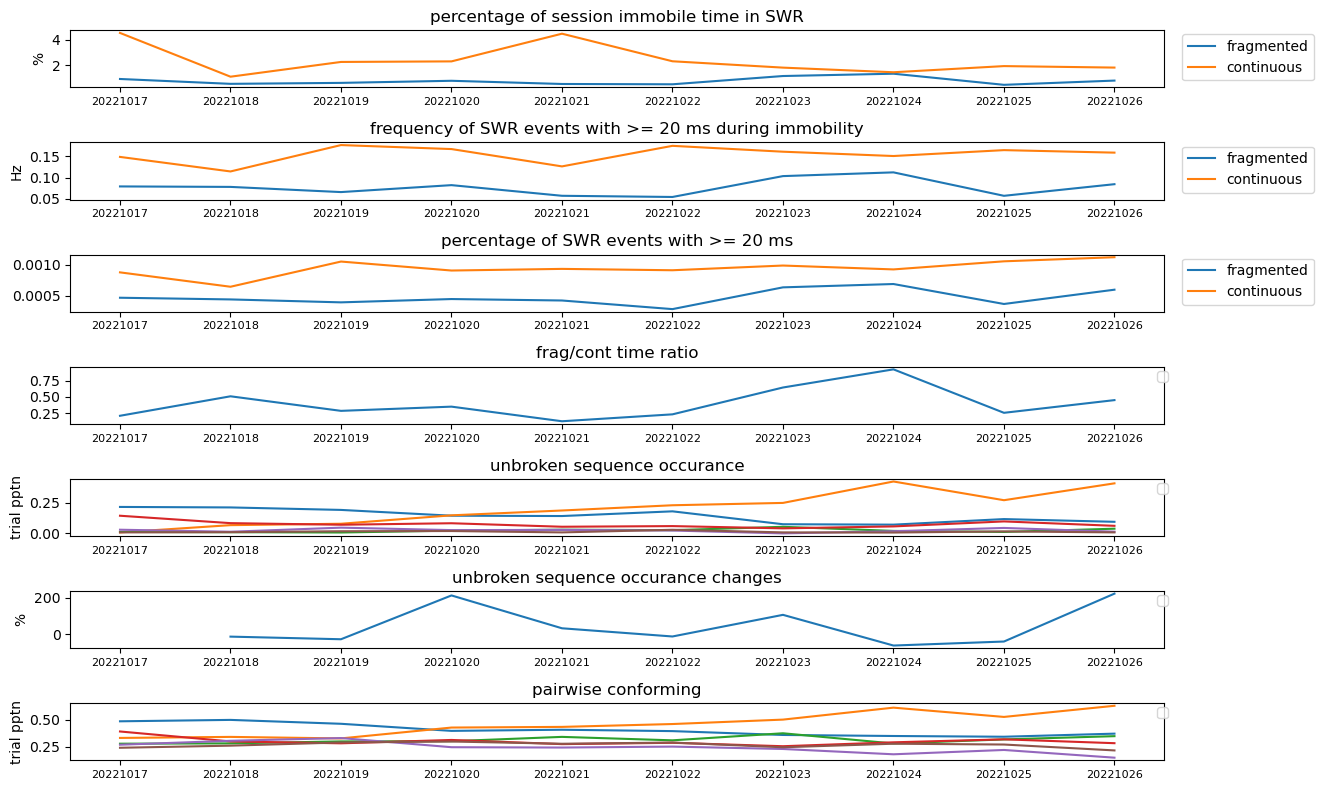

In [95]:
fig, axes = plt.subplots(7,1, figsize = (8 * len(time_frag_day)/6,8), sharex = True)
axes[0].plot(np.array(time_frag_day) * 100, label = 'fragmented')
axes[0].plot(np.array(time_cont_day) * 100, label = 'continuous')
axes[0].set_xticks(np.arange(len(dates_to_plot)));
axes[0].set_xticklabels(dates_to_plot,fontsize = 8);
axes[0].set_title('percentage of session immobile time in SWR')
axes[0].set_ylabel('%')
axes[0].legend(bbox_to_anchor=(1.01, 1.05))
axes[0].xaxis.set_tick_params(labelbottom=True)

axes[1].plot(num_frag_day, label = 'fragmented')
axes[1].plot(num_cont_day, label = 'continuous')
axes[1].set_xticks(np.arange(len(dates_to_plot)));
axes[1].set_xticklabels(dates_to_plot,fontsize = 8);
axes[1].set_title('frequency of SWR events with >= 20 ms during immobility')
axes[1].set_ylabel('Hz')
axes[1].legend(bbox_to_anchor=(1.01, 1.05))
axes[1].xaxis.set_tick_params(labelbottom=True)

axes[2].plot(pct_frag_day, label = 'fragmented')
axes[2].plot(pct_cont_day, label = 'continuous')
axes[2].set_xticks(np.arange(len(dates_to_plot)));
axes[2].set_xticklabels(dates_to_plot,fontsize = 8);
axes[2].set_title('percentage of SWR events with >= 20 ms')
axes[2].legend(bbox_to_anchor=(1.01, 1.05))
axes[2].xaxis.set_tick_params(labelbottom=True)

axes[3].plot(np.array(time_frag_day)/np.array(time_cont_day))
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[3].set_xticks(np.arange(len(dates_to_plot)));
axes[3].set_xticklabels(dates_to_plot,fontsize = 8);
axes[3].set_title('frag/cont time ratio')
axes[3].legend(bbox_to_anchor=(1.01, 1.05))
axes[3].xaxis.set_tick_params(labelbottom=True)

axes[4].plot(occurance_rates_day)
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[4].set_xticks(np.arange(len(dates_to_plot)));
axes[4].set_xticklabels(dates_to_plot,fontsize = 8);
axes[4].set_title('unbroken sequence occurance')
axes[4].set_ylabel('trial pptn')
axes[4].legend(bbox_to_anchor=(1.01, 1.05))
axes[4].xaxis.set_tick_params(labelbottom=True)

axes[5].plot(np.arange(len(dates_to_plot))[1:], pct_increase_day)
#axes[2].plot(pct_cont_day, label = 'continuous')
axes[5].set_xticks(np.arange(len(dates_to_plot)-1));
axes[5].set_xticklabels(dates_to_plot[1:],fontsize = 8);
axes[5].set_title('unbroken sequence occurance changes')
axes[5].set_ylabel('%')
axes[5].legend(bbox_to_anchor=(1.01, 1.05))
axes[5].xaxis.set_tick_params(labelbottom=True)

axes[6].plot(pairwise_day)
axes[6].set_xticks(np.arange(len(dates_to_plot)));
axes[6].set_xticklabels(dates_to_plot,fontsize = 8);
axes[6].set_title('pairwise conforming')
axes[6].set_ylabel('trial pptn')
axes[6].legend(bbox_to_anchor=(1.01, 1.05))
axes[6].xaxis.set_tick_params(labelbottom=True)

fig.tight_layout()

### Below are the same notebook as (Offline Ripple Analysis) 4. PairwiseBehaviorAndReplay 

In [ ]:
encoding_set = '2Dheadspeed_above_4_andlowmua'
classifier_param_name = 'default_decoding_gpu_4armMaze'

count, P_replay_all = replay_transitions(animal,dates_to_plot,encoding_set,classifier_param_name)
P_behavior_all,xcorr_plot,xcorr25_plot,xcorr975_plot = behavior_transitions(animal,dates_to_plot)
C_behavior_all, C_behavior_reward_all = behavior_transitions_count(animal,dates_to_plot)

#### 1. Row normalized (conditional probablity)

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.8, '0.8')]

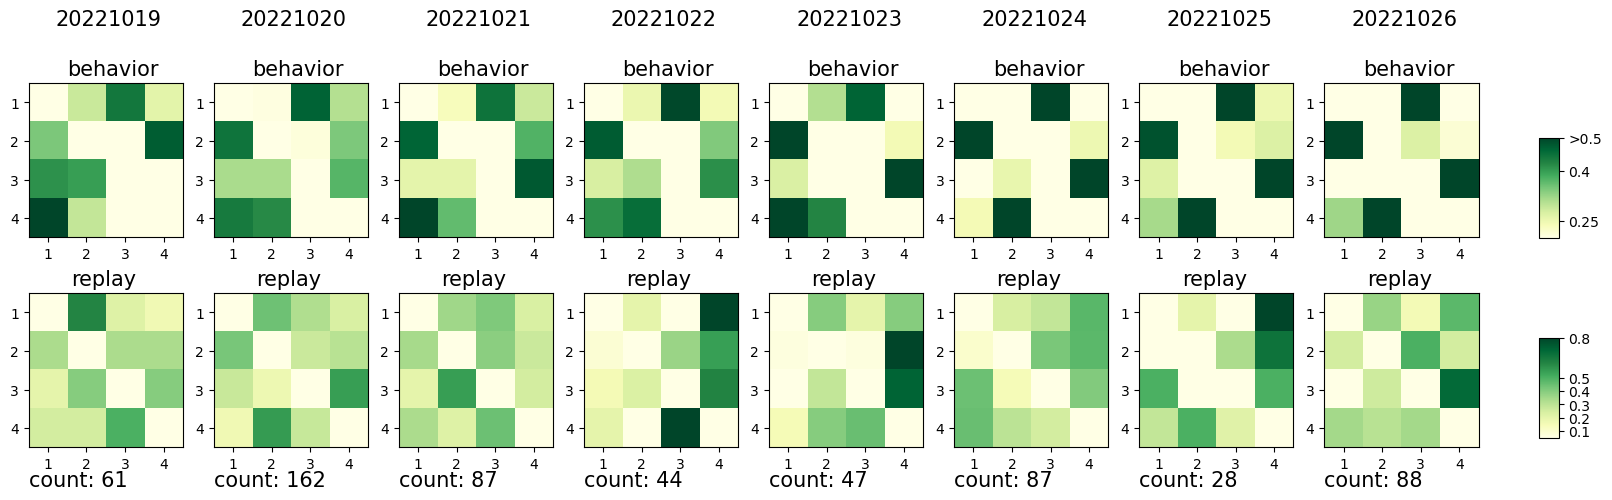

In [305]:
version = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 0.8
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = P_behavior_all[d]
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0.2, vmax = 0.5, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0.05, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.5,-0.7,'behavior',fontsize = 15)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, 0.5])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>0.5'])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', str(REPLAY_VMAX)])  # vertically oriented colorbar

#### 2. Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 25.0, '>25')]

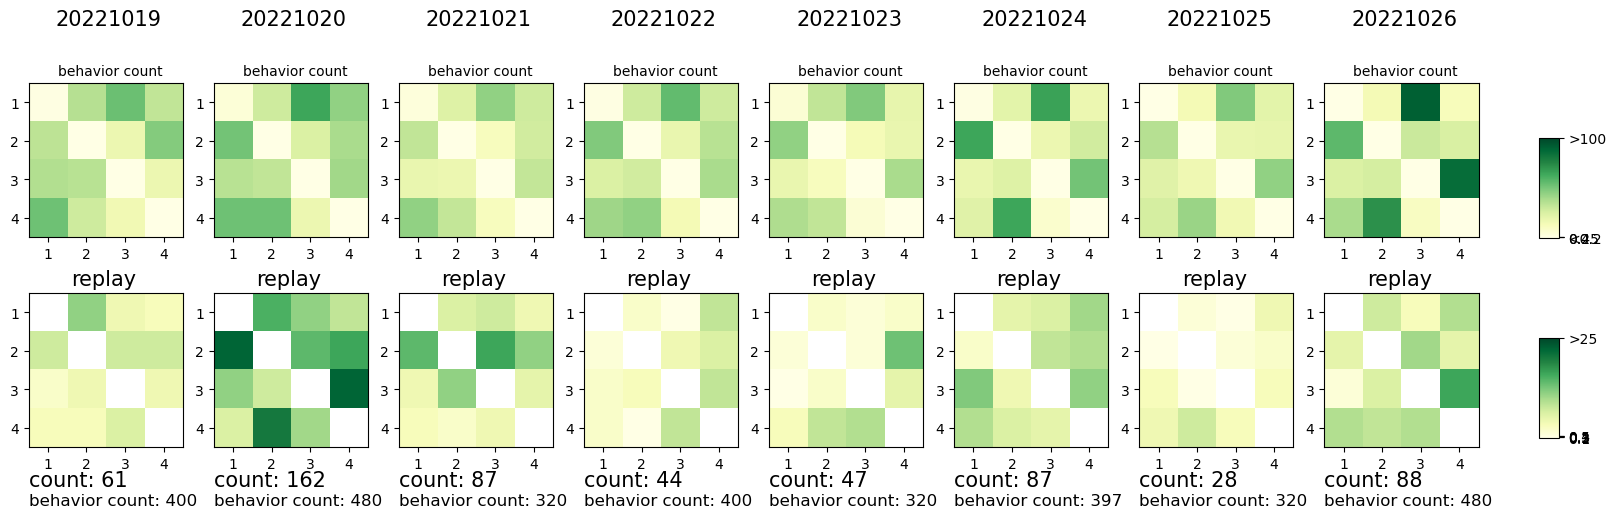

In [411]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 25
BEHAVIOR_VMAX = 100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)

    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.25,-0.7,'behavior count',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 3. Rewarded Transition Behavior Count

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 25.0, '>25')]

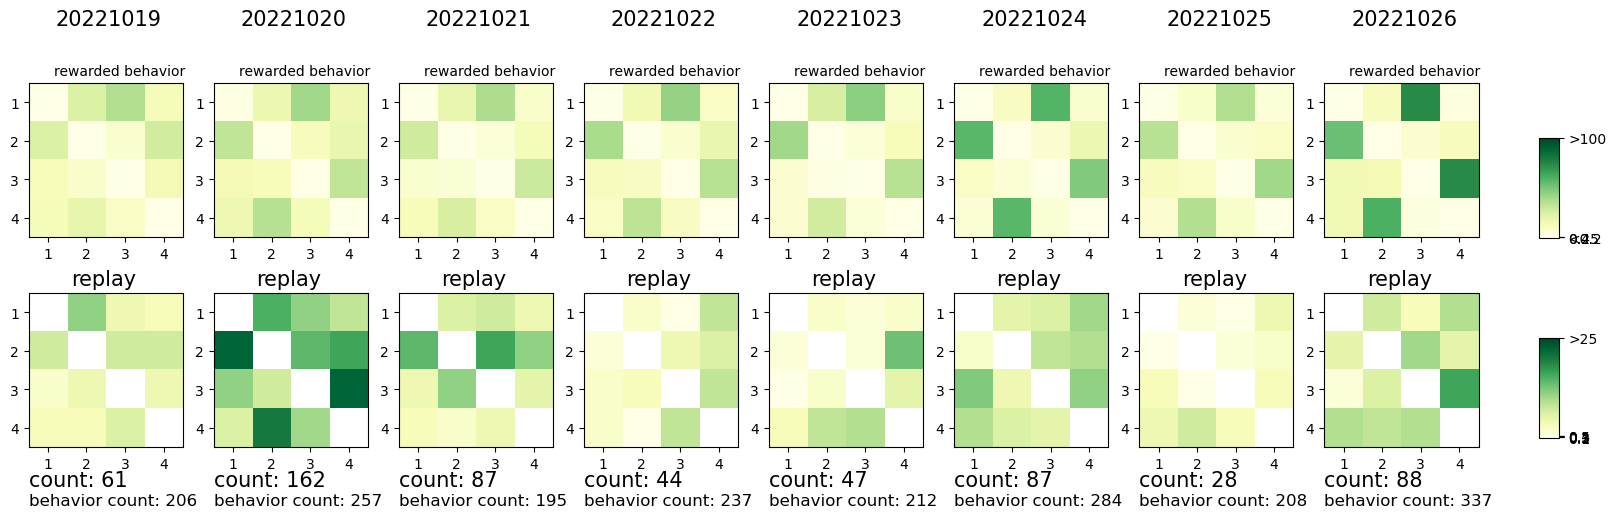

In [441]:
version = 0
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

REPLAY_VMAX = 25
BEHAVIOR_VMAX = 100 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    behavior_data = C_behavior_reward_all[d]#/np.sum(C_behavior_all[d])
    #axes[0,d_ind].imshow(behavior_data, vmax = np.nanquantile(behavior_data,0.9), origin = 'upper')
    im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'count: ' + str(int(count[d]))
    im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0.6,-0.7,'replay',fontsize = 15)
    
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 15)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(0.15,-0.7,'rewarded behavior',fontsize = 10)


# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.2', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 4. delta reward

[Text(1, 0.1, '0.1'),
 Text(1, 0.2, '>0.2'),
 Text(1, 0.3, '0.3'),
 Text(1, 0.4, '0.4'),
 Text(1, 0.5, '0.5'),
 Text(1, 0.2, '>0.2')]

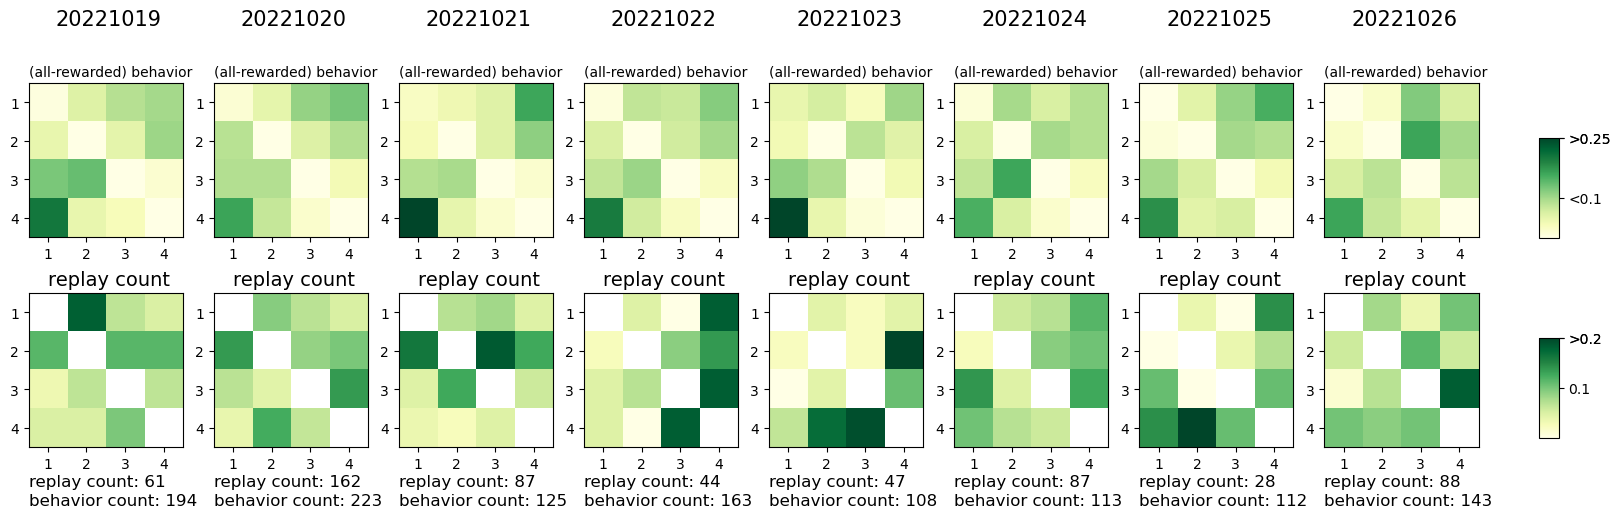

In [440]:
version = 0
normalize = 1
fig,axes = plt.subplots(2,len(dates_to_plot),figsize = (20,5))

if normalize:
    REPLAY_VMAX = 0.2
    BEHAVIOR_VMAX = 0.25
else:
    REPLAY_VMAX = 20
    BEHAVIOR_VMAX = 40 #0.25
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    d_minus1 = dates_to_plot[d_ind-1]
    behavior_data = (C_behavior_all[d]-C_behavior_reward_all[d])#/np.sum(C_behavior_all[d])
    if normalize:
        behavior_data_plot = behavior_data/np.sum(behavior_data)
        im1 = axes[0,d_ind].imshow(behavior_data_plot, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im1 = axes[0,d_ind].imshow(behavior_data, vmin = 0, vmax = BEHAVIOR_VMAX, origin = 'upper',cmap = 'YlGn')

    replay_data = P_replay_all[d][version]
    replay_count = 'replay count: ' + str(int(count[d]))
    if normalize:
        replay_data = replay_data/np.nansum(replay_data)
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    else:
        im2 = axes[1,d_ind].imshow(replay_data, vmin = 0, vmax = REPLAY_VMAX, origin = 'upper',cmap = 'YlGn')
    #axes[1,d_ind].imshow(replay_data, vmax = np.nanquantile(replay_data,0.9), origin = 'upper')
    axes[1,d_ind].text(0,-0.7,'replay count',fontsize = 14)
    axes[1,d_ind].text(-0.5,4.5,replay_count,fontsize = 12)
    behavior_count = 'behavior count: ' + str(int(np.sum(behavior_data)))
    axes[1,d_ind].text(-0.5,5,behavior_count,fontsize = 12)
    
    # label arms
    for ai in [0,1]:
        axes[ai,d_ind].set_xticks(np.arange(4))
        axes[ai,d_ind].set_yticks(np.arange(4))
        axes[ai,d_ind].set_xticklabels(['1','2','3','4'])
        axes[ai,d_ind].set_yticklabels(['1','2','3','4'])

    axes[0,d_ind].text(0.2,-2,d,fontsize = 15)
    axes[0,d_ind].text(-0.5,-0.7,'(all-rewarded) behavior',fontsize = 10)

# add space for colour bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.55, 0.01, 0.2])
fig.colorbar(im1, cax=cbar_ax,ticks=[0.1, 0.25, 0.4, BEHAVIOR_VMAX])
cbar_ax.set_yticklabels(['<0.1', '0.25', '0.4', '>'+str(BEHAVIOR_VMAX)])  # vertically oriented colorbar

cbar_ax = fig.add_axes([0.88, 0.15, 0.01, 0.2])
fig.colorbar(im2, cax=cbar_ax,ticks=[0.1, 0.2, 0.3, 0.4, 0.5, REPLAY_VMAX])
cbar_ax.set_yticklabels(['0.1', '0.2', '0.3', '0.4', '0.5', '>'+str(REPLAY_VMAX)])  # vertically oriented colorbar


#### 5. Trial-by-trial analysis

In [854]:
from spyglass.shijiegu.pairwiseDecode import trial_by_trial_behavior_replay_pairs,trial_by_trial_random_behavior_replay_pairs

LOOK_BACK_NUM = 2
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [ ]:
LOOK_BACK_NUM = 2
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

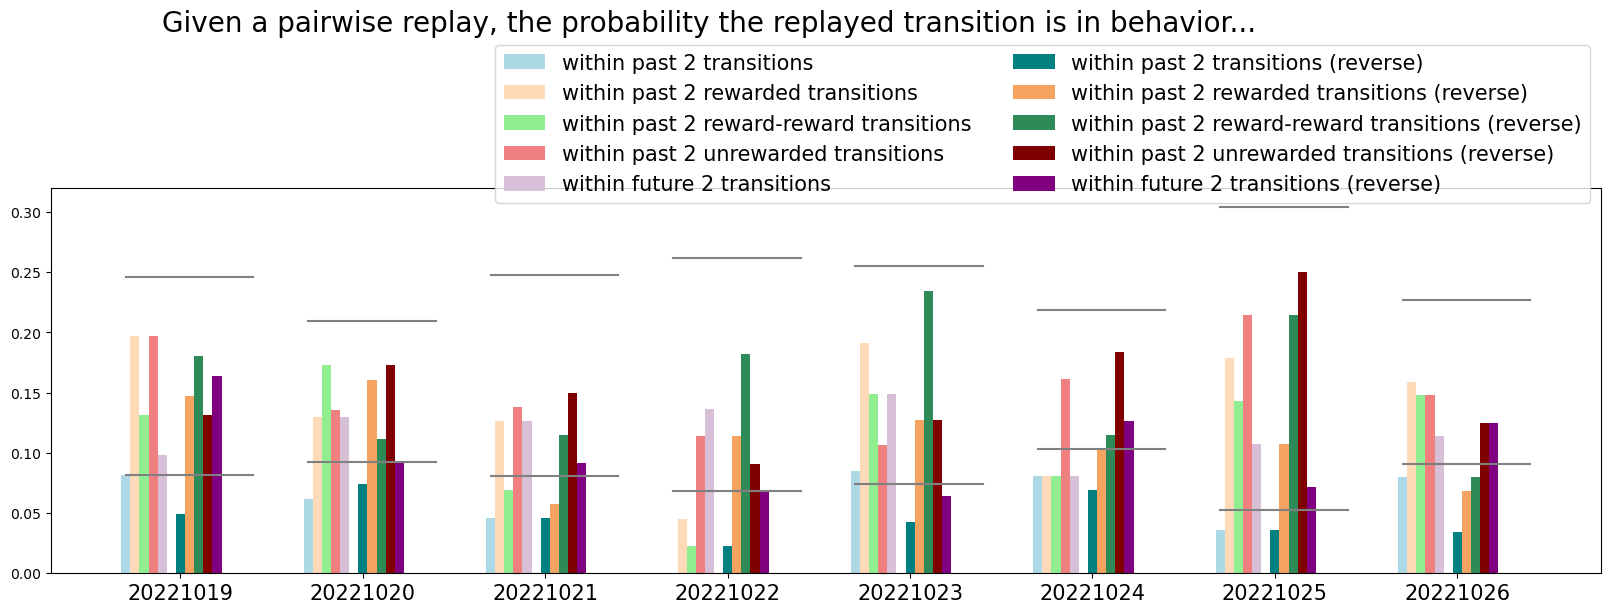

In [868]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.45,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

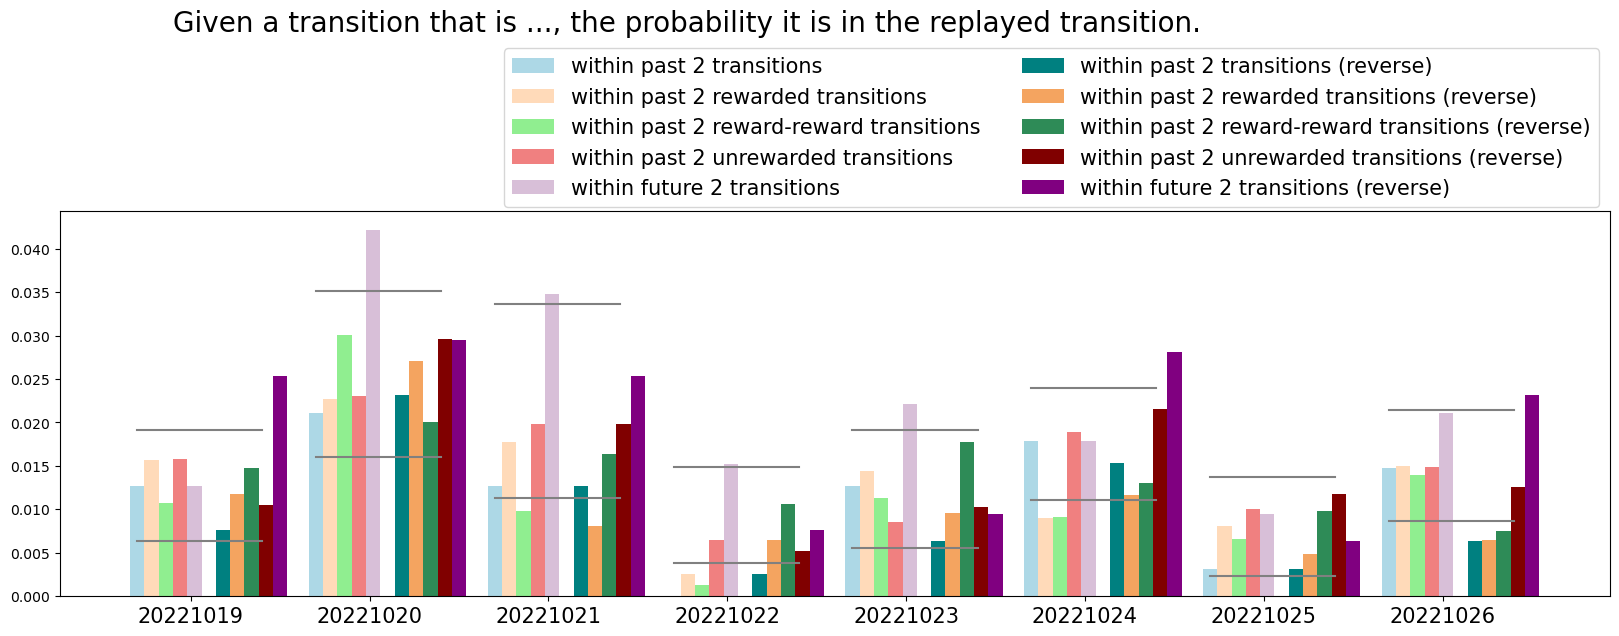

In [875]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.08
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_transition_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_transition_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_transition_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_transition_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_transition_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_transition_random_25[d],p_transition_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_transition_random_975[d],p_transition_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)


"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_transition_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_transition_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_transition_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_transition_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_transition_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.065,'Given a transition that is ..., the probability it is in the replayed transition.',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.45))

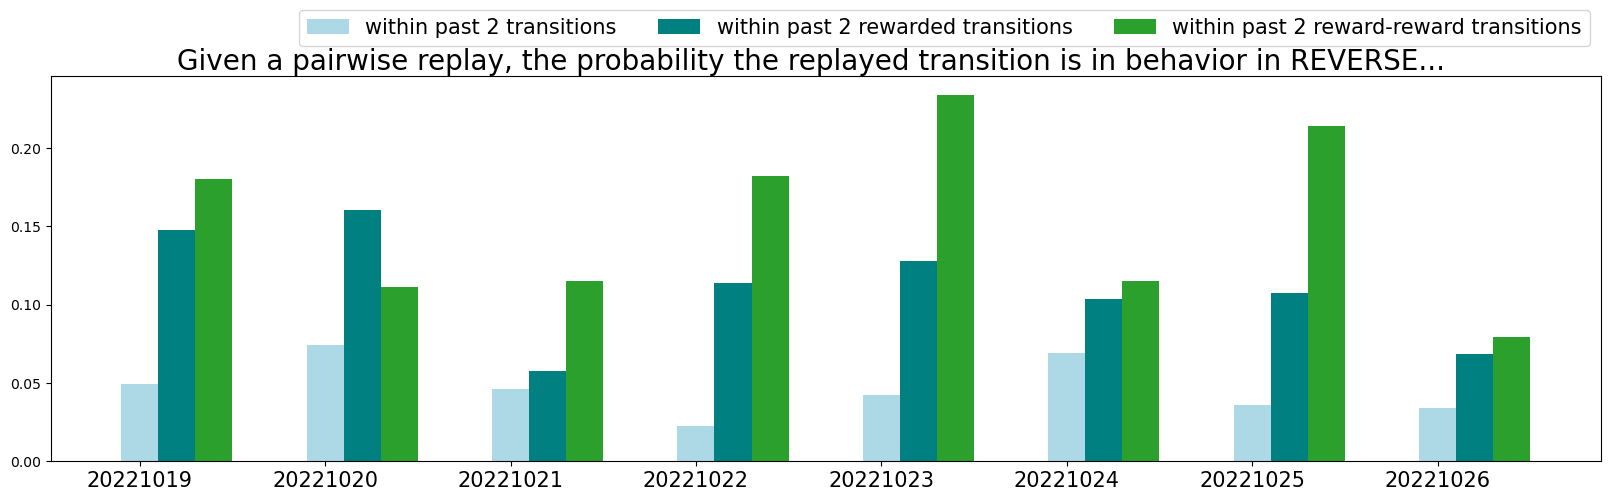

In [683]:
### In the case of just wanting one set
fig,axes = plt.subplots(1,1,figsize = (20,5))
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = 0.2)
        axes.bar(i+0.2,p_replay_reward[d],color = 'teal',width = 0.2)
        axes.bar(i+0.4,p_replay_reward_reward[d],color = 'C2',width = 0.2)
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot)))
axes.set_xticklabels(dates_to_plot,fontsize = 15)
axes.text(0.2,axes.get_ylim()[1] + 0.1,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);

In [878]:
LOOK_BACK_NUM = 1
(p_replay_reward, count_reward, 
 p_transition_reward, count_transition_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST_REWARD')
(p_replay_reward_reward, count_reward_reward,
 p_transition_reward_reward, count_transition_reward_reward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','REWARD_REWARD')
(p_replay_nonreward, count_nonreward,
 p_transition_nonreward, count_transition_nonreward) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','NONREWARD')
(p_replay_all, count_all,
 p_transition_all, count_transition_all) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'normal','PAST')
(p_replay_fu, count_fu,
 p_transition_fu, count_transition_fu) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'normal','FUTURE')

(p_replay_reward_r, count_reward_r,
  p_transition_reward_r, count_transition_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST_REWARD')
(p_replay_reward_reward_r, count_reward_reward_r,
 p_transition_reward_reward_r, count_transition_reward_reward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','REWARD_REWARD')
(p_replay_nonreward_r, count_nonreward_r,
 p_transition_nonreward_r, count_transition_nonreward_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','NONREWARD')
(p_replay_all_r, count_all_r,
 p_transition_all_r, count_transition_all_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                             classifier_param_name,LOOK_BACK_NUM,'reverse','PAST')
(p_replay_fu_r, count_fu_r,
 p_transition_fu_r, count_transition_fu_r) = trial_by_trial_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','FUTURE')

In [879]:
LOOK_BACK_NUM = 1
(p_replay_random_mean, p_replay_random_25, p_replay_random_975,
            p_transition_random_mean, p_transition_random_25, p_transition_random_975) = trial_by_trial_random_behavior_replay_pairs(animal,dates_to_plot,encoding_set,
                                                classifier_param_name,LOOK_BACK_NUM,'reverse','RANDOM')

working on bootstrap iteration: 0
working on bootstrap iteration: 1
working on bootstrap iteration: 2
working on bootstrap iteration: 3
working on bootstrap iteration: 4
working on bootstrap iteration: 5
working on bootstrap iteration: 6
working on bootstrap iteration: 7
working on bootstrap iteration: 8
working on bootstrap iteration: 9
working on bootstrap iteration: 10
working on bootstrap iteration: 11
working on bootstrap iteration: 12
working on bootstrap iteration: 13
working on bootstrap iteration: 14
working on bootstrap iteration: 15
working on bootstrap iteration: 16
working on bootstrap iteration: 17
working on bootstrap iteration: 18
working on bootstrap iteration: 19
working on bootstrap iteration: 20
working on bootstrap iteration: 21
working on bootstrap iteration: 22
working on bootstrap iteration: 23
working on bootstrap iteration: 24
working on bootstrap iteration: 25
working on bootstrap iteration: 26
working on bootstrap iteration: 27
working on bootstrap iteration

In [877]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/pairwiseDecode.py(324)trial_by_trial_behavior_replay_pairs_day()
    322         denominator_transition += denominator_transition_
    323     return (nominator_replay/denominator_replay,denominator_replay,
--> 324             nominator_transition/denominator_transition,denominator_transition)
    325 
    326 



ipdb>  nominator_transition


0


ipdb>  exit


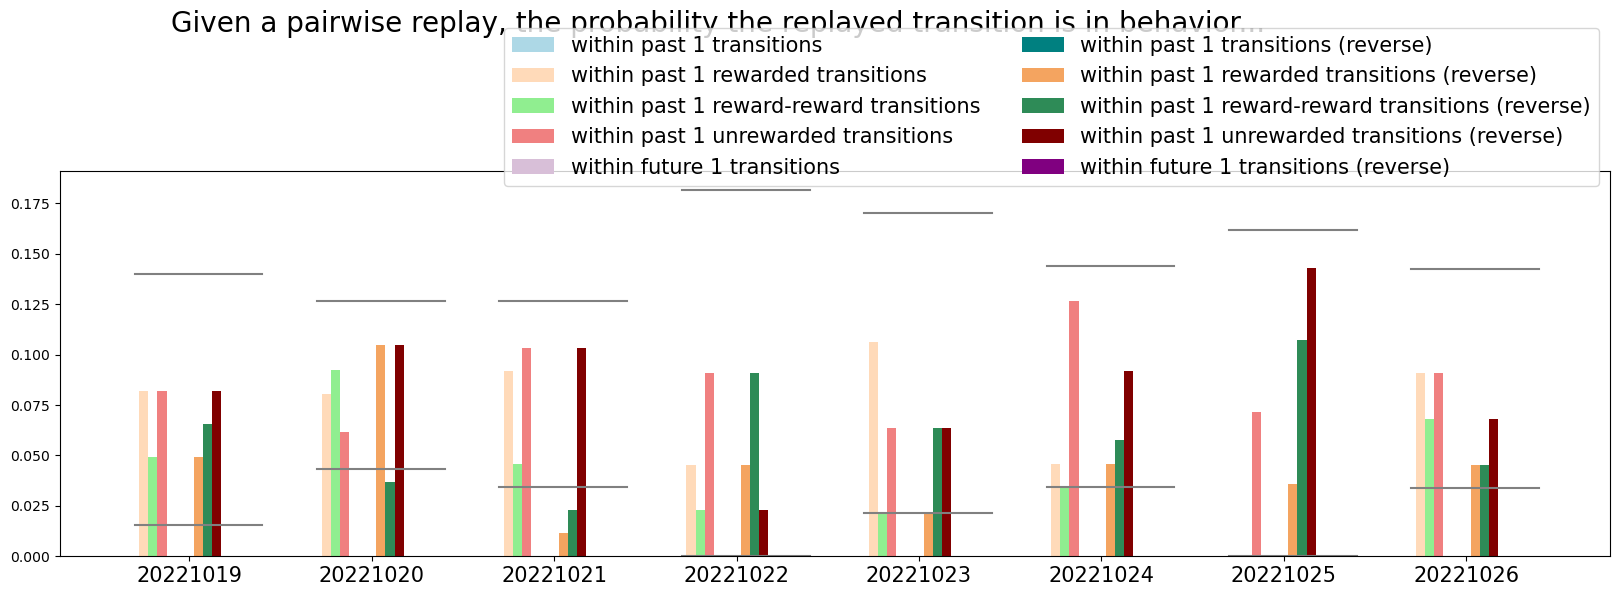

In [885]:
fig,axes = plt.subplots(1,1,figsize = (20,5))
WIDTH = 0.05
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions')
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions')
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions')
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions')
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions')
    else:
        axes.bar(i,p_replay_all[d],color = 'lightblue',width = WIDTH)
        axes.bar(i+WIDTH,p_replay_reward[d],color = 'peachpuff',width = WIDTH)
        axes.bar(i+2*WIDTH,p_replay_reward_reward[d],color = 'lightgreen',width = WIDTH)
        axes.bar(i+3*WIDTH,p_replay_nonreward[d],color = 'lightcoral',width = WIDTH)
        axes.bar(i+4*WIDTH,p_replay_fu[d],color = 'thistle',width = WIDTH)
        
    axes.plot([i, i+0.7],[p_replay_random_25[d],p_replay_random_25[d]],color = 'grey')
    axes.plot([i, i+0.7],[p_replay_random_975[d],p_replay_random_975[d]],color = 'grey')
    
axes.legend(loc='upper right', ncols=3,fontsize = 15,bbox_to_anchor=(1, 1.2))

axes.set_xticks(np.arange(len(dates_to_plot))+0.3)
axes.set_xticklabels(dates_to_plot,fontsize = 15)

"""reverse analysis"""
for i in range(len(dates_to_plot)):
    d = dates_to_plot[i]
    if i == 0:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH,label = f'within past {LOOK_BACK_NUM} transitions (reverse)')
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH,label = f'within past {LOOK_BACK_NUM} rewarded transitions (reverse)')
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH,label = f'within past {LOOK_BACK_NUM} reward-reward transitions (reverse)')
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH,label = f'within past {LOOK_BACK_NUM} unrewarded transitions (reverse)')
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH,label = f'within future {LOOK_BACK_NUM} transitions (reverse)')
    else:
        axes.bar(i+6*WIDTH,p_replay_all_r[d],color = 'teal',width = WIDTH)
        axes.bar(i+7*WIDTH,p_replay_reward_r[d],color = 'sandybrown',width = WIDTH)
        axes.bar(i+8*WIDTH,p_replay_reward_reward_r[d],color = 'seagreen',width = WIDTH)
        axes.bar(i+9*WIDTH,p_replay_nonreward_r[d],color = 'maroon',width = WIDTH)
        axes.bar(i+10*WIDTH,p_replay_fu_r[d],color = 'purple',width = WIDTH)

axes.text(0.2,0.26,'Given a pairwise replay, the probability the replayed transition is in behavior...',fontsize = 20);
axes.legend(loc='upper right', ncols=2,fontsize = 15,bbox_to_anchor=(1, 1.4))

### Plot 1b. Find intersection events

In [256]:
key_acausal = {'nwb_file_name': 'eliot20221023_.nwb',
        'interval_list_name': '02_Seq2Session1',
        'classifier_param_name':'default_decoding_gpu_4armMaze',
        'encoding_set':encoding_set}
key_causal = key_acausal.copy()
key_causal['classifier_param_name'] = 'causal_decoding_gpu_4armMaze'

trials_a = pd.DataFrame((TrialChoiceReplayTransition & key_acausal).fetch1('choice_reward_replay_transition'))
trials_c = pd.DataFrame((TrialChoiceReplayTransition & key_causal).fetch1('choice_reward_replay_transition'))

In [274]:
transition_session = np.zeros((4,4))

for t in [60]:#trials_a.index:
    r_a = set(trials_a.loc[t].replayed_transitions)
    r_c = set(trials_c.loc[t].replayed_transitions)
    common_t = r_a.intersection(r_c)
    for ct in common_t:
        i = int(ct[0])-1
        j = int(ct[1])-1
        transition_session[i,j] += 1

In [275]:
common_t

set()

In [261]:
transition_session

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [2., 1., 1., 0.]])

In [121]:
trials_c.loc[18].replayed_transitions

[]

In [133]:
a = set([(2,4),(1,3)])
b = set([(2,4),(1,3)])

In [135]:
c = a.intersection(b)

In [136]:
c

{(1, 3), (2, 4)}

### Plot 2. Correlation with the sequence

In [302]:
version = 2
transition_dict = {}
for d_ind in range(len(dates_to_plot)):
    d = dates_to_plot[d_ind]
    transition_dict[d] = P_replay_all[d][version]
    
xcorr_replay_plot= findXCorrAllDays(transition_dict)

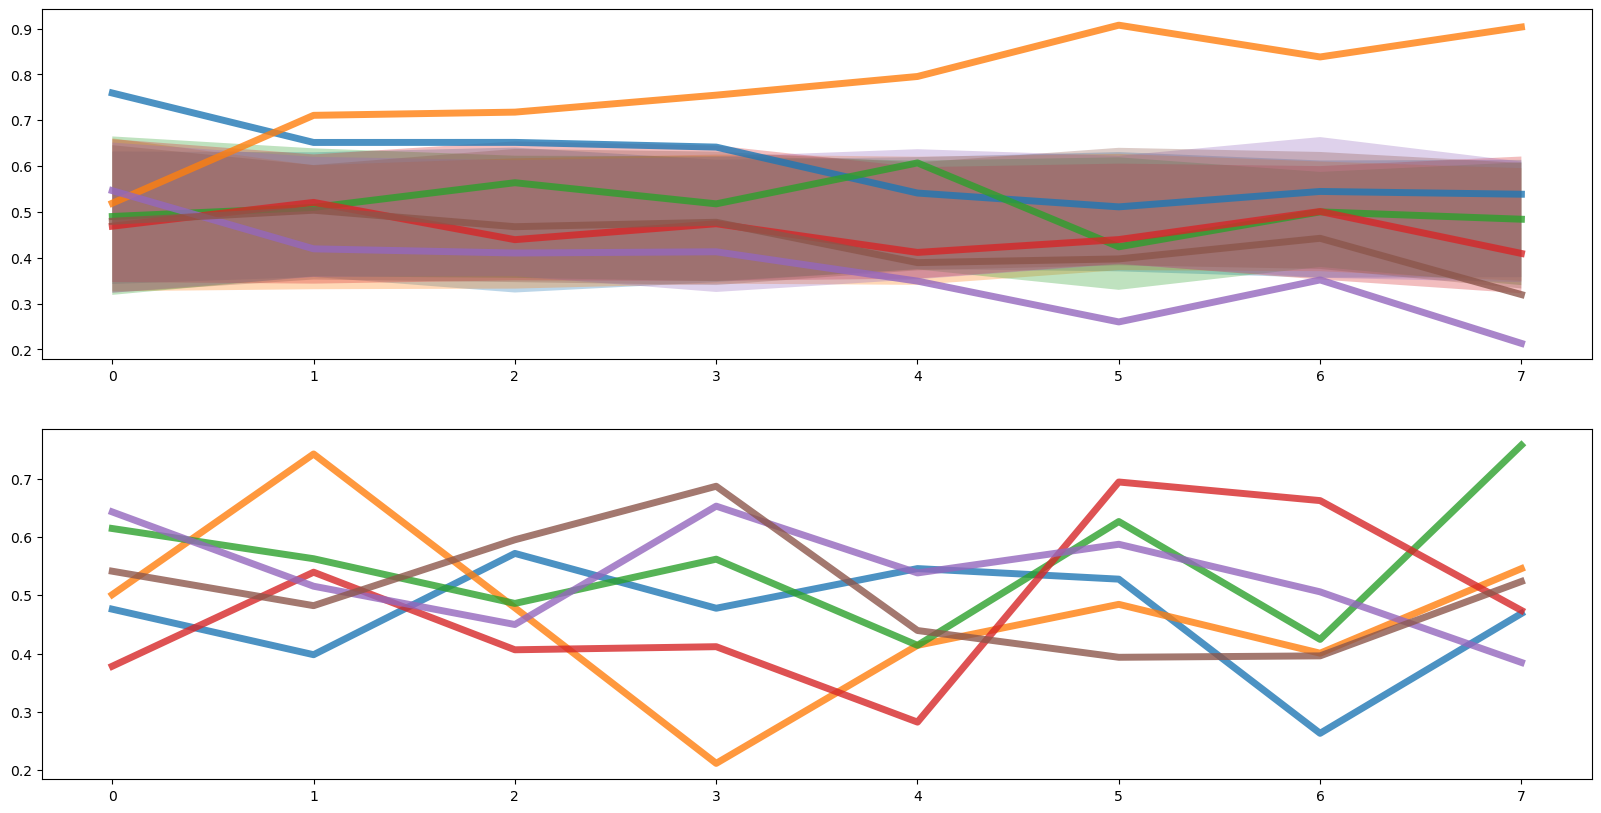

In [303]:
f,axes = plt.subplots(2,1,figsize = (20,10))
for seq_ind in range(6):
    axes[0].plot(xcorr_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)
    axes[0].fill_between(np.arange(len(dates_to_plot)),
                    xcorr25_plot[:,seq_ind],
                    xcorr975_plot[:,seq_ind], facecolor='C'+str(seq_ind), alpha=0.3)

for seq_ind in range(6):
    axes[1].plot(xcorr_replay_plot[:,seq_ind],'C'+str(seq_ind),linewidth = 5,alpha=0.8)

### Investigate another session

In [224]:
session_interval

['02_Seq2Session1', '04_Seq2Session2', '06_Seq2Session3', '08_Seq2Session4']

In [48]:
key = {'nwb_file_name': nwb_copy_file_name, 'interval_list_name': '04_Seq2Session2'}
T_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'choice_reward_replay_transition'))
matrix_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'transitions'))

In [49]:
T_transition_[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
1,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,[],"[[[1666467957.1042895, 1666467957.1802895], [1...",[],"[[[4], [4], [2]]]",[],[1],2.0,2.0,4.0,NaN,NaN
2,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,[],"[[[1666467971.4162765, 1666467971.910276]]]",[],[[[4]]],[],[2],4.0,4.0,3.0,2.0,NaN
3,1.666468e+09,1.0,1.666468e+09,3.0,"[(1, 3)]",2.0,"[[[1666467986.9242623, 1666467987.114262], [16...",[],"[[[0, 3], [0]], [[0]], [[1], [3]]]",[],"[3, 4, 5]",[],3.0,3.0,1.0,4.0,NaN
4,1.666468e+09,1.0,1.666468e+09,1.0,[],1.0,"[[[1666468033.5662196, 1666468033.8102193]]]",[],[[[0]]],[],[6],[],1.0,1.0,4.0,3.0,3.0
5,1.666468e+09,1.0,1.666468e+09,4.0,[],2.0,"[[[1666468058.1321971, 1666468058.2501972], [1...","[[[1666468074.1761825, 1666468074.3281825], [1...","[[[0], [2], [], []], [[0], [3], []]]","[[[4], [], []], [[], [0]], [[3, 4]], [[4]]]","[7, 8]","[9, 10, 11, 12]",4.0,4.0,2.0,1.0,3.0
6,1.666468e+09,1.0,1.666468e+09,2.0,[],2.0,"[[[1666468091.9001665, 1666468092.0261662], [1...","[[[1666468100.436159, 1666468100.7301583]], [[...","[[[0], [0]], [[], []]]","[[[2]], [[2, 3], [3], [2]], [[2]], [[2], [2]]]","[13, 14]","[15, 16, 17, 18]",2.0,2.0,3.0,4.0,4.0
7,1.666468e+09,1.0,1.666468e+09,3.0,[],1.0,"[[[1666468129.8861315, 1666468130.0101316], [1...",[],"[[[], [], [], [0]], [[], [0]]]",[],"[19, 20]",[],3.0,3.0,1.0,2.0,2.0
8,1.666468e+09,1.0,1.666468e+09,1.0,[],2.0,"[[[1666468148.7041144, 1666468148.9621143], [1...","[[[1666468162.6301017, 1666468162.7521017], [1...","[[[0, 3], [], [0]]]","[[[], [], [], [0]]]",[21],[22],1.0,1.0,4.0,3.0,2.0
9,1.666468e+09,1.0,1.666468e+09,4.0,[],1.0,"[[[1666468180.2980857, 1666468180.5160854], [1...",[],"[[[0], [0]], [[0, 2], [], [0], [], [0]], [[0]]...",[],"[23, 24, 25, 26, 27]",[],4.0,4.0,2.0,1.0,1.0
10,1.666468e+09,1.0,1.666468e+09,2.0,[],1.0,"[[[1666468201.668066, 1666468201.784066], [166...",[],"[[[], [], [0]]]",[],[28],[],2.0,2.0,1.0,4.0,1.0


In [227]:
matrix_transition_ 

,0,1,2,3
0,7.0,0.0,0.0,1.0
1,0.0,3.0,0.0,2.0
2,0.0,2.0,7.0,0.0
3,0.0,9.0,2.0,17.0
